In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('celeba', data_dir)

Found celeba Data


In [3]:
show_n_images = 25

# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

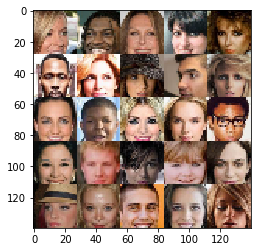

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))


## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = "real_image")
    z_image = tf.placeholder(tf.float32, [None, z_dim], name = "z_image")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")
    
    return real_image, z_image, learning_rate

### Discriminator
Implement `discriminator` 

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse = reuse):
        # 28*28
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = "same")
        relu1 = tf.maximum(alpha*x1, x1)
        
        # 14*14
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = "same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        
        # Flaten the image
        flaten = tf.reshape(relu2, (-1, 7*7*128))
        logist = tf.layers.dense(flaten, 1)
        output = tf.sigmoid(logist)

    return output, logist

### Generator
Implement `generator` to generate an image using `z`.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse = not is_train):
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        
        # Reshape it to an image
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        bn1 = tf.layers.batch_normalization(x1, training = is_train)
        relu1 = tf.maximum(bn1*alpha, bn1)
        
        # 7*7*128
        x2 = tf.layers.conv2d_transpose(relu1, 64, 5, strides = 2, padding = "same")
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(bn2*alpha, bn2)
        
        # 14*14*64
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides = 2, padding = "same")
        
        out = tf.tanh(logits)
    
    return out

### Loss
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    real_image, z_image, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_image, z_image, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_image: batch_images, z_image: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_image: batch_z, lr:learning_rate})
                
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_image: batch_z, real_image: batch_images})
                    train_loss_g = g_loss.eval({z_image: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, z_image, data_shape[3],  data_image_mode)
                    

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

('Epoch 1/4...', 'Discriminator Loss: 1.1117...', 'Generator Loss: 0.8139')
('Epoch 1/4...', 'Discriminator Loss: 0.8010...', 'Generator Loss: 1.4410')
('Epoch 1/4...', 'Discriminator Loss: 0.6730...', 'Generator Loss: 1.6051')
('Epoch 1/4...', 'Discriminator Loss: 0.6488...', 'Generator Loss: 1.9145')
('Epoch 1/4...', 'Discriminator Loss: 0.5859...', 'Generator Loss: 2.0229')
('Epoch 1/4...', 'Discriminator Loss: 0.6442...', 'Generator Loss: 1.7832')
('Epoch 1/4...', 'Discriminator Loss: 0.6378...', 'Generator Loss: 1.7178')
('Epoch 1/4...', 'Discriminator Loss: 1.5971...', 'Generator Loss: 0.4102')
('Epoch 1/4...', 'Discriminator Loss: 0.8524...', 'Generator Loss: 1.7683')
('Epoch 1/4...', 'Discriminator Loss: 0.8902...', 'Generator Loss: 1.6241')


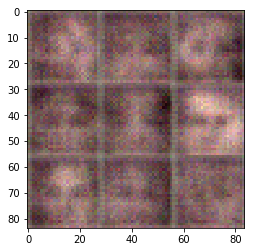

('Epoch 1/4...', 'Discriminator Loss: 0.9913...', 'Generator Loss: 1.8281')
('Epoch 1/4...', 'Discriminator Loss: 0.8561...', 'Generator Loss: 1.3994')
('Epoch 1/4...', 'Discriminator Loss: 0.9507...', 'Generator Loss: 1.7143')
('Epoch 1/4...', 'Discriminator Loss: 0.9156...', 'Generator Loss: 1.9887')
('Epoch 1/4...', 'Discriminator Loss: 0.9888...', 'Generator Loss: 1.1252')
('Epoch 1/4...', 'Discriminator Loss: 0.9520...', 'Generator Loss: 0.9716')
('Epoch 1/4...', 'Discriminator Loss: 0.8490...', 'Generator Loss: 1.8536')
('Epoch 1/4...', 'Discriminator Loss: 0.9208...', 'Generator Loss: 1.0947')
('Epoch 1/4...', 'Discriminator Loss: 0.8721...', 'Generator Loss: 1.4112')
('Epoch 1/4...', 'Discriminator Loss: 0.8484...', 'Generator Loss: 1.2533')


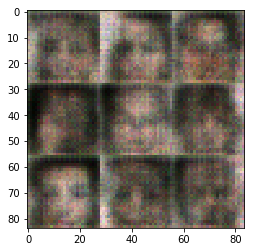

('Epoch 1/4...', 'Discriminator Loss: 0.8138...', 'Generator Loss: 1.3426')
('Epoch 1/4...', 'Discriminator Loss: 1.0514...', 'Generator Loss: 2.1814')
('Epoch 1/4...', 'Discriminator Loss: 1.0078...', 'Generator Loss: 1.2586')
('Epoch 1/4...', 'Discriminator Loss: 1.0854...', 'Generator Loss: 1.2861')
('Epoch 1/4...', 'Discriminator Loss: 1.1853...', 'Generator Loss: 1.5026')
('Epoch 1/4...', 'Discriminator Loss: 1.0324...', 'Generator Loss: 1.0228')
('Epoch 1/4...', 'Discriminator Loss: 1.2674...', 'Generator Loss: 0.7062')
('Epoch 1/4...', 'Discriminator Loss: 1.0113...', 'Generator Loss: 1.3621')
('Epoch 1/4...', 'Discriminator Loss: 1.1165...', 'Generator Loss: 1.5907')
('Epoch 1/4...', 'Discriminator Loss: 1.1672...', 'Generator Loss: 0.8907')


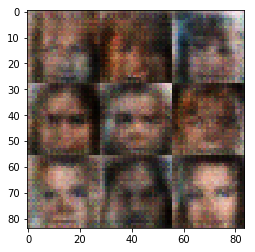

('Epoch 1/4...', 'Discriminator Loss: 1.2451...', 'Generator Loss: 0.8156')
('Epoch 1/4...', 'Discriminator Loss: 1.2834...', 'Generator Loss: 1.0186')
('Epoch 1/4...', 'Discriminator Loss: 1.1910...', 'Generator Loss: 1.0407')
('Epoch 1/4...', 'Discriminator Loss: 1.1181...', 'Generator Loss: 1.0923')
('Epoch 1/4...', 'Discriminator Loss: 1.2269...', 'Generator Loss: 0.6710')
('Epoch 1/4...', 'Discriminator Loss: 1.0257...', 'Generator Loss: 1.4428')
('Epoch 1/4...', 'Discriminator Loss: 1.1079...', 'Generator Loss: 0.8266')
('Epoch 1/4...', 'Discriminator Loss: 1.1193...', 'Generator Loss: 0.9822')
('Epoch 1/4...', 'Discriminator Loss: 1.1101...', 'Generator Loss: 0.9408')
('Epoch 1/4...', 'Discriminator Loss: 1.1176...', 'Generator Loss: 1.1744')


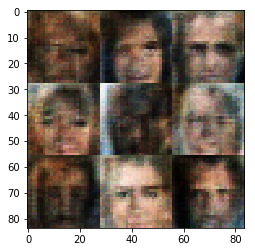

('Epoch 1/4...', 'Discriminator Loss: 1.0084...', 'Generator Loss: 1.1913')
('Epoch 1/4...', 'Discriminator Loss: 1.0088...', 'Generator Loss: 1.1580')
('Epoch 1/4...', 'Discriminator Loss: 1.0833...', 'Generator Loss: 0.9634')
('Epoch 1/4...', 'Discriminator Loss: 1.0907...', 'Generator Loss: 0.8038')
('Epoch 1/4...', 'Discriminator Loss: 1.2289...', 'Generator Loss: 0.6055')
('Epoch 1/4...', 'Discriminator Loss: 1.5970...', 'Generator Loss: 2.1169')
('Epoch 1/4...', 'Discriminator Loss: 1.0402...', 'Generator Loss: 1.0169')
('Epoch 1/4...', 'Discriminator Loss: 0.9955...', 'Generator Loss: 1.1805')
('Epoch 1/4...', 'Discriminator Loss: 0.9931...', 'Generator Loss: 1.0301')
('Epoch 1/4...', 'Discriminator Loss: 1.0004...', 'Generator Loss: 1.1596')


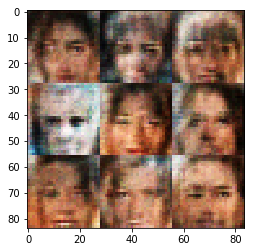

('Epoch 1/4...', 'Discriminator Loss: 1.2825...', 'Generator Loss: 1.7951')
('Epoch 1/4...', 'Discriminator Loss: 1.1266...', 'Generator Loss: 0.8258')
('Epoch 1/4...', 'Discriminator Loss: 1.0567...', 'Generator Loss: 1.2455')
('Epoch 1/4...', 'Discriminator Loss: 1.1557...', 'Generator Loss: 0.7111')
('Epoch 1/4...', 'Discriminator Loss: 0.8962...', 'Generator Loss: 1.1982')
('Epoch 1/4...', 'Discriminator Loss: 0.8090...', 'Generator Loss: 1.6533')
('Epoch 1/4...', 'Discriminator Loss: 0.8068...', 'Generator Loss: 1.5858')
('Epoch 1/4...', 'Discriminator Loss: 0.8000...', 'Generator Loss: 1.1569')
('Epoch 1/4...', 'Discriminator Loss: 0.9148...', 'Generator Loss: 1.1939')
('Epoch 1/4...', 'Discriminator Loss: 1.3693...', 'Generator Loss: 0.5273')


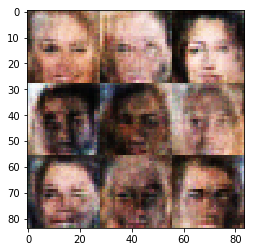

('Epoch 1/4...', 'Discriminator Loss: 0.9275...', 'Generator Loss: 1.2356')
('Epoch 1/4...', 'Discriminator Loss: 1.0350...', 'Generator Loss: 1.0524')
('Epoch 1/4...', 'Discriminator Loss: 1.0298...', 'Generator Loss: 1.1919')
('Epoch 1/4...', 'Discriminator Loss: 1.0625...', 'Generator Loss: 1.2147')
('Epoch 1/4...', 'Discriminator Loss: 0.9796...', 'Generator Loss: 1.0472')
('Epoch 1/4...', 'Discriminator Loss: 1.0949...', 'Generator Loss: 0.9016')
('Epoch 1/4...', 'Discriminator Loss: 1.0832...', 'Generator Loss: 1.0720')
('Epoch 1/4...', 'Discriminator Loss: 1.1265...', 'Generator Loss: 0.8123')
('Epoch 1/4...', 'Discriminator Loss: 1.2285...', 'Generator Loss: 0.7396')
('Epoch 1/4...', 'Discriminator Loss: 1.0356...', 'Generator Loss: 1.2640')


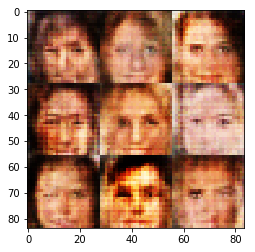

('Epoch 1/4...', 'Discriminator Loss: 1.4784...', 'Generator Loss: 0.5561')
('Epoch 1/4...', 'Discriminator Loss: 1.1670...', 'Generator Loss: 1.2160')
('Epoch 1/4...', 'Discriminator Loss: 1.1834...', 'Generator Loss: 1.1573')
('Epoch 1/4...', 'Discriminator Loss: 1.0746...', 'Generator Loss: 1.0617')
('Epoch 1/4...', 'Discriminator Loss: 1.2594...', 'Generator Loss: 0.7172')
('Epoch 1/4...', 'Discriminator Loss: 1.0725...', 'Generator Loss: 1.3278')
('Epoch 1/4...', 'Discriminator Loss: 1.0319...', 'Generator Loss: 1.0991')
('Epoch 1/4...', 'Discriminator Loss: 1.2078...', 'Generator Loss: 0.8462')
('Epoch 1/4...', 'Discriminator Loss: 1.0695...', 'Generator Loss: 1.2050')
('Epoch 1/4...', 'Discriminator Loss: 1.1842...', 'Generator Loss: 0.9744')


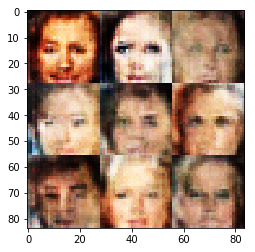

('Epoch 1/4...', 'Discriminator Loss: 1.2056...', 'Generator Loss: 0.8705')
('Epoch 1/4...', 'Discriminator Loss: 1.1940...', 'Generator Loss: 1.4674')
('Epoch 1/4...', 'Discriminator Loss: 1.3169...', 'Generator Loss: 0.8781')
('Epoch 1/4...', 'Discriminator Loss: 1.3502...', 'Generator Loss: 0.7597')
('Epoch 1/4...', 'Discriminator Loss: 1.2872...', 'Generator Loss: 0.6312')
('Epoch 1/4...', 'Discriminator Loss: 1.0792...', 'Generator Loss: 1.1186')
('Epoch 1/4...', 'Discriminator Loss: 1.3100...', 'Generator Loss: 0.7295')
('Epoch 1/4...', 'Discriminator Loss: 1.1678...', 'Generator Loss: 1.0098')
('Epoch 1/4...', 'Discriminator Loss: 1.1129...', 'Generator Loss: 1.2443')
('Epoch 1/4...', 'Discriminator Loss: 1.3396...', 'Generator Loss: 0.7584')


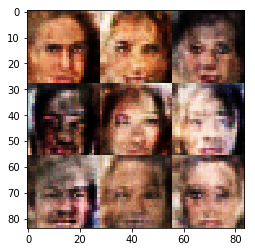

('Epoch 1/4...', 'Discriminator Loss: 1.1259...', 'Generator Loss: 1.0161')
('Epoch 1/4...', 'Discriminator Loss: 1.3366...', 'Generator Loss: 0.6865')
('Epoch 1/4...', 'Discriminator Loss: 1.3377...', 'Generator Loss: 0.7121')
('Epoch 1/4...', 'Discriminator Loss: 1.2078...', 'Generator Loss: 0.8642')
('Epoch 1/4...', 'Discriminator Loss: 1.1454...', 'Generator Loss: 1.0364')
('Epoch 1/4...', 'Discriminator Loss: 1.1859...', 'Generator Loss: 1.0251')
('Epoch 1/4...', 'Discriminator Loss: 1.2393...', 'Generator Loss: 1.2113')
('Epoch 1/4...', 'Discriminator Loss: 1.3036...', 'Generator Loss: 0.8670')
('Epoch 1/4...', 'Discriminator Loss: 1.3787...', 'Generator Loss: 1.3991')
('Epoch 1/4...', 'Discriminator Loss: 1.2259...', 'Generator Loss: 0.8360')


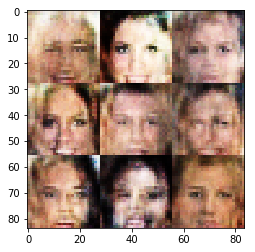

('Epoch 1/4...', 'Discriminator Loss: 1.2221...', 'Generator Loss: 1.1306')
('Epoch 1/4...', 'Discriminator Loss: 1.2234...', 'Generator Loss: 0.8050')
('Epoch 1/4...', 'Discriminator Loss: 1.1346...', 'Generator Loss: 1.0208')
('Epoch 1/4...', 'Discriminator Loss: 1.2130...', 'Generator Loss: 0.9031')
('Epoch 1/4...', 'Discriminator Loss: 1.2517...', 'Generator Loss: 0.8714')
('Epoch 1/4...', 'Discriminator Loss: 1.2051...', 'Generator Loss: 1.1643')
('Epoch 1/4...', 'Discriminator Loss: 1.1942...', 'Generator Loss: 1.1799')
('Epoch 1/4...', 'Discriminator Loss: 1.1775...', 'Generator Loss: 1.1821')
('Epoch 1/4...', 'Discriminator Loss: 1.0906...', 'Generator Loss: 1.3498')
('Epoch 1/4...', 'Discriminator Loss: 1.1932...', 'Generator Loss: 0.8847')


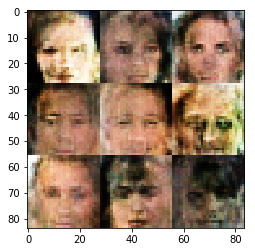

('Epoch 1/4...', 'Discriminator Loss: 1.2691...', 'Generator Loss: 0.8064')
('Epoch 1/4...', 'Discriminator Loss: 1.1608...', 'Generator Loss: 0.9916')
('Epoch 1/4...', 'Discriminator Loss: 1.2350...', 'Generator Loss: 0.8150')
('Epoch 1/4...', 'Discriminator Loss: 1.1668...', 'Generator Loss: 0.9919')
('Epoch 1/4...', 'Discriminator Loss: 1.0935...', 'Generator Loss: 1.1042')
('Epoch 1/4...', 'Discriminator Loss: 1.1940...', 'Generator Loss: 1.0858')
('Epoch 1/4...', 'Discriminator Loss: 1.1176...', 'Generator Loss: 0.9998')
('Epoch 1/4...', 'Discriminator Loss: 1.1357...', 'Generator Loss: 0.8493')
('Epoch 1/4...', 'Discriminator Loss: 1.1281...', 'Generator Loss: 0.8937')
('Epoch 1/4...', 'Discriminator Loss: 1.1220...', 'Generator Loss: 1.2176')


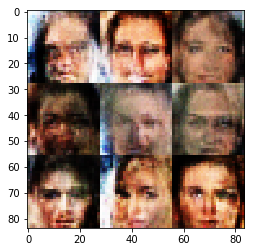

('Epoch 1/4...', 'Discriminator Loss: 1.1736...', 'Generator Loss: 1.0682')
('Epoch 1/4...', 'Discriminator Loss: 1.3143...', 'Generator Loss: 0.6987')
('Epoch 1/4...', 'Discriminator Loss: 1.2241...', 'Generator Loss: 0.8692')
('Epoch 1/4...', 'Discriminator Loss: 1.1120...', 'Generator Loss: 1.3018')
('Epoch 1/4...', 'Discriminator Loss: 1.1302...', 'Generator Loss: 1.1456')
('Epoch 1/4...', 'Discriminator Loss: 1.2461...', 'Generator Loss: 1.3702')
('Epoch 1/4...', 'Discriminator Loss: 1.1742...', 'Generator Loss: 0.9780')
('Epoch 1/4...', 'Discriminator Loss: 1.1672...', 'Generator Loss: 1.0957')
('Epoch 1/4...', 'Discriminator Loss: 1.1093...', 'Generator Loss: 0.9819')
('Epoch 1/4...', 'Discriminator Loss: 1.0759...', 'Generator Loss: 1.0717')


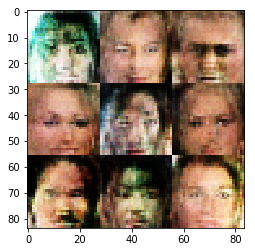

('Epoch 1/4...', 'Discriminator Loss: 1.0832...', 'Generator Loss: 1.3571')
('Epoch 1/4...', 'Discriminator Loss: 1.1069...', 'Generator Loss: 1.1576')
('Epoch 1/4...', 'Discriminator Loss: 1.2932...', 'Generator Loss: 0.9326')
('Epoch 1/4...', 'Discriminator Loss: 1.1101...', 'Generator Loss: 1.2339')
('Epoch 1/4...', 'Discriminator Loss: 1.0768...', 'Generator Loss: 0.9389')
('Epoch 1/4...', 'Discriminator Loss: 1.0361...', 'Generator Loss: 1.2635')
('Epoch 1/4...', 'Discriminator Loss: 1.0684...', 'Generator Loss: 1.0571')
('Epoch 1/4...', 'Discriminator Loss: 1.0614...', 'Generator Loss: 1.0840')
('Epoch 1/4...', 'Discriminator Loss: 1.0642...', 'Generator Loss: 1.1335')
('Epoch 1/4...', 'Discriminator Loss: 1.2027...', 'Generator Loss: 0.7544')


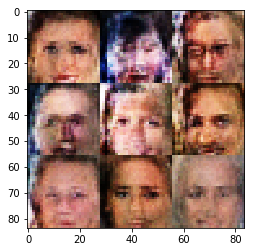

('Epoch 1/4...', 'Discriminator Loss: 1.2419...', 'Generator Loss: 0.8932')
('Epoch 1/4...', 'Discriminator Loss: 1.2163...', 'Generator Loss: 1.2913')
('Epoch 1/4...', 'Discriminator Loss: 1.0277...', 'Generator Loss: 1.3320')
('Epoch 1/4...', 'Discriminator Loss: 1.1243...', 'Generator Loss: 1.0550')
('Epoch 1/4...', 'Discriminator Loss: 1.0649...', 'Generator Loss: 0.9884')
('Epoch 1/4...', 'Discriminator Loss: 1.0530...', 'Generator Loss: 1.5486')
('Epoch 1/4...', 'Discriminator Loss: 1.0915...', 'Generator Loss: 1.1854')
('Epoch 1/4...', 'Discriminator Loss: 1.2226...', 'Generator Loss: 0.6617')
('Epoch 1/4...', 'Discriminator Loss: 1.1364...', 'Generator Loss: 0.8963')
('Epoch 1/4...', 'Discriminator Loss: 1.0242...', 'Generator Loss: 1.2425')


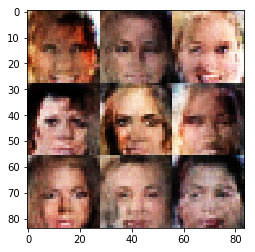

('Epoch 1/4...', 'Discriminator Loss: 1.0248...', 'Generator Loss: 1.4842')
('Epoch 1/4...', 'Discriminator Loss: 1.0792...', 'Generator Loss: 1.0310')
('Epoch 1/4...', 'Discriminator Loss: 1.2194...', 'Generator Loss: 1.4949')
('Epoch 1/4...', 'Discriminator Loss: 1.0993...', 'Generator Loss: 1.4382')
('Epoch 1/4...', 'Discriminator Loss: 1.0685...', 'Generator Loss: 0.9210')
('Epoch 1/4...', 'Discriminator Loss: 1.2609...', 'Generator Loss: 0.7447')
('Epoch 1/4...', 'Discriminator Loss: 1.1634...', 'Generator Loss: 1.1661')
('Epoch 1/4...', 'Discriminator Loss: 1.1115...', 'Generator Loss: 1.1095')
('Epoch 1/4...', 'Discriminator Loss: 1.1554...', 'Generator Loss: 0.9097')
('Epoch 1/4...', 'Discriminator Loss: 1.1485...', 'Generator Loss: 1.2753')


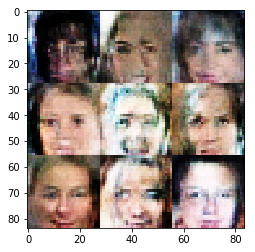

('Epoch 1/4...', 'Discriminator Loss: 1.1136...', 'Generator Loss: 1.2903')
('Epoch 1/4...', 'Discriminator Loss: 1.2339...', 'Generator Loss: 0.9976')
('Epoch 1/4...', 'Discriminator Loss: 1.1558...', 'Generator Loss: 0.7741')
('Epoch 1/4...', 'Discriminator Loss: 1.1441...', 'Generator Loss: 1.1181')
('Epoch 1/4...', 'Discriminator Loss: 1.0752...', 'Generator Loss: 0.9212')
('Epoch 1/4...', 'Discriminator Loss: 1.0522...', 'Generator Loss: 0.9997')
('Epoch 1/4...', 'Discriminator Loss: 1.0204...', 'Generator Loss: 1.3094')
('Epoch 1/4...', 'Discriminator Loss: 1.2504...', 'Generator Loss: 0.7647')
('Epoch 1/4...', 'Discriminator Loss: 1.1302...', 'Generator Loss: 1.1357')
('Epoch 1/4...', 'Discriminator Loss: 1.2514...', 'Generator Loss: 0.7327')


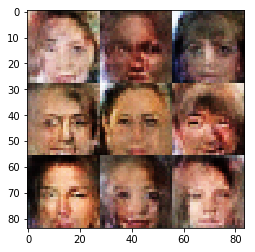

('Epoch 1/4...', 'Discriminator Loss: 1.1871...', 'Generator Loss: 0.9440')
('Epoch 1/4...', 'Discriminator Loss: 1.1220...', 'Generator Loss: 0.8065')
('Epoch 1/4...', 'Discriminator Loss: 1.1337...', 'Generator Loss: 1.2045')
('Epoch 1/4...', 'Discriminator Loss: 1.0457...', 'Generator Loss: 0.9197')
('Epoch 1/4...', 'Discriminator Loss: 1.0873...', 'Generator Loss: 0.8714')
('Epoch 1/4...', 'Discriminator Loss: 1.2563...', 'Generator Loss: 1.5355')
('Epoch 1/4...', 'Discriminator Loss: 1.1072...', 'Generator Loss: 1.4897')
('Epoch 1/4...', 'Discriminator Loss: 1.2542...', 'Generator Loss: 0.7620')
('Epoch 1/4...', 'Discriminator Loss: 1.1584...', 'Generator Loss: 0.9539')
('Epoch 1/4...', 'Discriminator Loss: 1.1224...', 'Generator Loss: 0.9870')


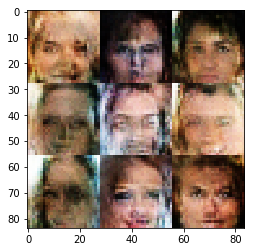

('Epoch 1/4...', 'Discriminator Loss: 1.1690...', 'Generator Loss: 0.7630')
('Epoch 1/4...', 'Discriminator Loss: 1.2734...', 'Generator Loss: 1.4411')
('Epoch 1/4...', 'Discriminator Loss: 1.4009...', 'Generator Loss: 0.5723')
('Epoch 1/4...', 'Discriminator Loss: 1.0210...', 'Generator Loss: 1.4559')
('Epoch 1/4...', 'Discriminator Loss: 1.2322...', 'Generator Loss: 0.8774')
('Epoch 1/4...', 'Discriminator Loss: 1.2503...', 'Generator Loss: 1.5317')
('Epoch 1/4...', 'Discriminator Loss: 1.2726...', 'Generator Loss: 0.6367')
('Epoch 1/4...', 'Discriminator Loss: 1.2505...', 'Generator Loss: 0.7749')
('Epoch 1/4...', 'Discriminator Loss: 1.1568...', 'Generator Loss: 0.9328')
('Epoch 1/4...', 'Discriminator Loss: 1.1125...', 'Generator Loss: 0.9714')


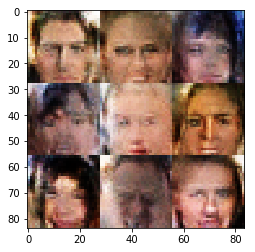

('Epoch 1/4...', 'Discriminator Loss: 1.1132...', 'Generator Loss: 1.1341')
('Epoch 1/4...', 'Discriminator Loss: 1.4043...', 'Generator Loss: 0.9068')
('Epoch 1/4...', 'Discriminator Loss: 1.2548...', 'Generator Loss: 0.6635')
('Epoch 1/4...', 'Discriminator Loss: 1.1269...', 'Generator Loss: 0.9228')
('Epoch 1/4...', 'Discriminator Loss: 1.0983...', 'Generator Loss: 1.0040')
('Epoch 1/4...', 'Discriminator Loss: 1.2611...', 'Generator Loss: 1.0380')
('Epoch 1/4...', 'Discriminator Loss: 1.0761...', 'Generator Loss: 0.9611')
('Epoch 1/4...', 'Discriminator Loss: 1.1508...', 'Generator Loss: 0.9387')
('Epoch 1/4...', 'Discriminator Loss: 1.1529...', 'Generator Loss: 0.8614')
('Epoch 1/4...', 'Discriminator Loss: 1.2191...', 'Generator Loss: 1.2617')


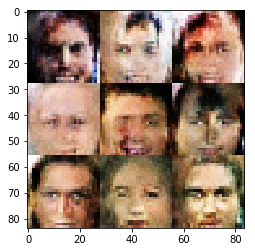

('Epoch 1/4...', 'Discriminator Loss: 1.2820...', 'Generator Loss: 0.7113')
('Epoch 1/4...', 'Discriminator Loss: 1.0808...', 'Generator Loss: 1.0717')
('Epoch 1/4...', 'Discriminator Loss: 0.9532...', 'Generator Loss: 1.2445')
('Epoch 1/4...', 'Discriminator Loss: 1.1062...', 'Generator Loss: 0.8499')
('Epoch 1/4...', 'Discriminator Loss: 1.0937...', 'Generator Loss: 0.9114')
('Epoch 1/4...', 'Discriminator Loss: 1.1123...', 'Generator Loss: 0.9136')
('Epoch 1/4...', 'Discriminator Loss: 1.0605...', 'Generator Loss: 1.0550')
('Epoch 1/4...', 'Discriminator Loss: 1.2130...', 'Generator Loss: 0.9978')
('Epoch 1/4...', 'Discriminator Loss: 1.1170...', 'Generator Loss: 0.9453')
('Epoch 1/4...', 'Discriminator Loss: 1.1634...', 'Generator Loss: 0.7521')


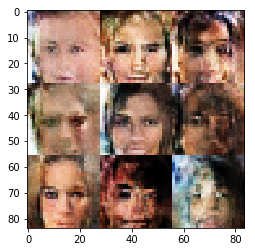

('Epoch 1/4...', 'Discriminator Loss: 1.2041...', 'Generator Loss: 0.9474')
('Epoch 1/4...', 'Discriminator Loss: 1.0981...', 'Generator Loss: 1.2032')
('Epoch 1/4...', 'Discriminator Loss: 1.1525...', 'Generator Loss: 1.0729')
('Epoch 1/4...', 'Discriminator Loss: 1.2136...', 'Generator Loss: 1.1854')
('Epoch 1/4...', 'Discriminator Loss: 1.2156...', 'Generator Loss: 1.1424')
('Epoch 1/4...', 'Discriminator Loss: 1.2370...', 'Generator Loss: 1.1027')
('Epoch 1/4...', 'Discriminator Loss: 1.1860...', 'Generator Loss: 1.1170')
('Epoch 1/4...', 'Discriminator Loss: 1.3828...', 'Generator Loss: 0.5615')
('Epoch 1/4...', 'Discriminator Loss: 1.1264...', 'Generator Loss: 1.2232')
('Epoch 1/4...', 'Discriminator Loss: 1.1749...', 'Generator Loss: 0.7992')


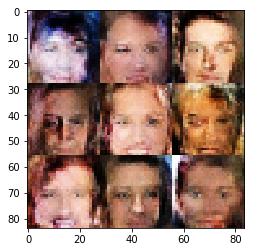

('Epoch 1/4...', 'Discriminator Loss: 1.1755...', 'Generator Loss: 0.9420')
('Epoch 1/4...', 'Discriminator Loss: 1.2689...', 'Generator Loss: 0.8761')
('Epoch 1/4...', 'Discriminator Loss: 1.0798...', 'Generator Loss: 0.9572')
('Epoch 1/4...', 'Discriminator Loss: 1.2257...', 'Generator Loss: 0.8566')
('Epoch 1/4...', 'Discriminator Loss: 1.1178...', 'Generator Loss: 1.2415')
('Epoch 1/4...', 'Discriminator Loss: 1.1761...', 'Generator Loss: 0.8479')
('Epoch 1/4...', 'Discriminator Loss: 1.2152...', 'Generator Loss: 0.7470')
('Epoch 1/4...', 'Discriminator Loss: 1.3804...', 'Generator Loss: 1.5401')
('Epoch 1/4...', 'Discriminator Loss: 1.1491...', 'Generator Loss: 1.0044')
('Epoch 1/4...', 'Discriminator Loss: 1.2787...', 'Generator Loss: 0.6062')


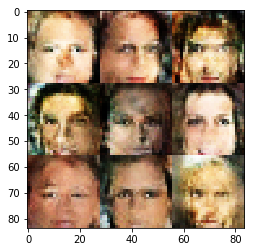

('Epoch 1/4...', 'Discriminator Loss: 1.2632...', 'Generator Loss: 1.2406')
('Epoch 1/4...', 'Discriminator Loss: 1.1451...', 'Generator Loss: 1.0741')
('Epoch 1/4...', 'Discriminator Loss: 1.2344...', 'Generator Loss: 0.9918')
('Epoch 1/4...', 'Discriminator Loss: 1.1725...', 'Generator Loss: 1.0391')
('Epoch 1/4...', 'Discriminator Loss: 1.2263...', 'Generator Loss: 0.7087')
('Epoch 1/4...', 'Discriminator Loss: 1.1817...', 'Generator Loss: 0.8141')
('Epoch 1/4...', 'Discriminator Loss: 1.4525...', 'Generator Loss: 1.8513')
('Epoch 1/4...', 'Discriminator Loss: 1.0853...', 'Generator Loss: 1.0599')
('Epoch 1/4...', 'Discriminator Loss: 1.2105...', 'Generator Loss: 0.7262')
('Epoch 1/4...', 'Discriminator Loss: 1.1642...', 'Generator Loss: 0.8836')


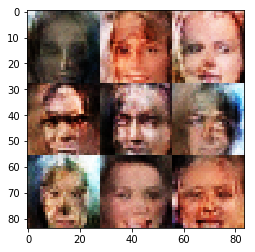

('Epoch 1/4...', 'Discriminator Loss: 1.2021...', 'Generator Loss: 0.9879')
('Epoch 1/4...', 'Discriminator Loss: 1.1724...', 'Generator Loss: 0.9556')
('Epoch 1/4...', 'Discriminator Loss: 1.4903...', 'Generator Loss: 0.4682')
('Epoch 1/4...', 'Discriminator Loss: 1.2153...', 'Generator Loss: 0.7988')
('Epoch 1/4...', 'Discriminator Loss: 1.0704...', 'Generator Loss: 1.0952')
('Epoch 1/4...', 'Discriminator Loss: 1.1601...', 'Generator Loss: 0.9041')
('Epoch 1/4...', 'Discriminator Loss: 1.0167...', 'Generator Loss: 1.0952')
('Epoch 1/4...', 'Discriminator Loss: 1.1939...', 'Generator Loss: 1.0179')
('Epoch 1/4...', 'Discriminator Loss: 1.1744...', 'Generator Loss: 1.1867')
('Epoch 1/4...', 'Discriminator Loss: 1.2573...', 'Generator Loss: 1.3912')


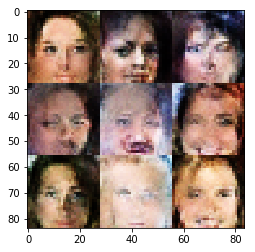

('Epoch 1/4...', 'Discriminator Loss: 1.3102...', 'Generator Loss: 0.6218')
('Epoch 1/4...', 'Discriminator Loss: 1.2179...', 'Generator Loss: 0.6607')
('Epoch 1/4...', 'Discriminator Loss: 1.0561...', 'Generator Loss: 1.0577')
('Epoch 1/4...', 'Discriminator Loss: 1.0913...', 'Generator Loss: 0.8956')
('Epoch 1/4...', 'Discriminator Loss: 1.1970...', 'Generator Loss: 1.2070')
('Epoch 1/4...', 'Discriminator Loss: 1.2066...', 'Generator Loss: 0.8299')
('Epoch 1/4...', 'Discriminator Loss: 1.0576...', 'Generator Loss: 1.3936')
('Epoch 1/4...', 'Discriminator Loss: 1.1566...', 'Generator Loss: 0.8465')
('Epoch 1/4...', 'Discriminator Loss: 1.0754...', 'Generator Loss: 0.9561')
('Epoch 1/4...', 'Discriminator Loss: 1.2644...', 'Generator Loss: 0.7279')


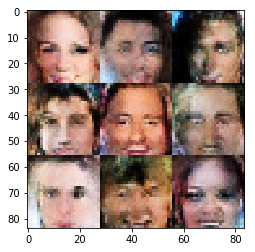

('Epoch 1/4...', 'Discriminator Loss: 1.0619...', 'Generator Loss: 1.0577')
('Epoch 1/4...', 'Discriminator Loss: 1.2388...', 'Generator Loss: 0.6932')
('Epoch 1/4...', 'Discriminator Loss: 1.1826...', 'Generator Loss: 1.2368')
('Epoch 1/4...', 'Discriminator Loss: 0.9840...', 'Generator Loss: 1.2886')
('Epoch 1/4...', 'Discriminator Loss: 1.3030...', 'Generator Loss: 0.5977')
('Epoch 1/4...', 'Discriminator Loss: 1.2239...', 'Generator Loss: 0.9429')
('Epoch 1/4...', 'Discriminator Loss: 1.1263...', 'Generator Loss: 1.0450')
('Epoch 1/4...', 'Discriminator Loss: 1.2678...', 'Generator Loss: 0.7487')
('Epoch 1/4...', 'Discriminator Loss: 1.0294...', 'Generator Loss: 1.0712')
('Epoch 1/4...', 'Discriminator Loss: 1.1442...', 'Generator Loss: 1.2166')


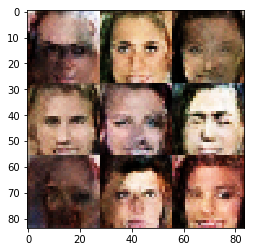

('Epoch 1/4...', 'Discriminator Loss: 1.3118...', 'Generator Loss: 0.7343')
('Epoch 1/4...', 'Discriminator Loss: 1.2031...', 'Generator Loss: 1.1579')
('Epoch 1/4...', 'Discriminator Loss: 1.0836...', 'Generator Loss: 0.9513')
('Epoch 1/4...', 'Discriminator Loss: 1.1486...', 'Generator Loss: 0.9776')
('Epoch 1/4...', 'Discriminator Loss: 1.0429...', 'Generator Loss: 1.3667')
('Epoch 1/4...', 'Discriminator Loss: 1.2890...', 'Generator Loss: 0.7056')
('Epoch 1/4...', 'Discriminator Loss: 1.0855...', 'Generator Loss: 0.9491')
('Epoch 1/4...', 'Discriminator Loss: 1.0339...', 'Generator Loss: 0.9477')
('Epoch 1/4...', 'Discriminator Loss: 1.1889...', 'Generator Loss: 0.8467')
('Epoch 1/4...', 'Discriminator Loss: 1.1749...', 'Generator Loss: 1.4002')


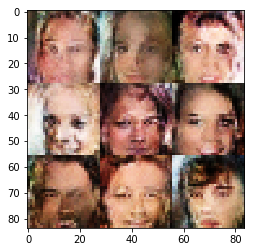

('Epoch 1/4...', 'Discriminator Loss: 1.0766...', 'Generator Loss: 1.6031')
('Epoch 1/4...', 'Discriminator Loss: 1.0830...', 'Generator Loss: 1.0015')
('Epoch 1/4...', 'Discriminator Loss: 1.0098...', 'Generator Loss: 1.1367')
('Epoch 1/4...', 'Discriminator Loss: 1.0946...', 'Generator Loss: 0.9593')
('Epoch 1/4...', 'Discriminator Loss: 1.0681...', 'Generator Loss: 0.9599')
('Epoch 1/4...', 'Discriminator Loss: 1.1788...', 'Generator Loss: 0.9275')
('Epoch 1/4...', 'Discriminator Loss: 0.9842...', 'Generator Loss: 1.3194')
('Epoch 1/4...', 'Discriminator Loss: 1.3510...', 'Generator Loss: 0.5270')
('Epoch 1/4...', 'Discriminator Loss: 1.1918...', 'Generator Loss: 0.8378')
('Epoch 1/4...', 'Discriminator Loss: 1.2561...', 'Generator Loss: 0.8443')


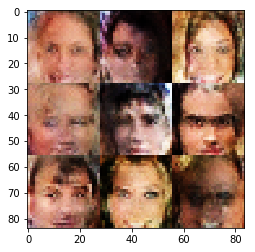

('Epoch 1/4...', 'Discriminator Loss: 1.2115...', 'Generator Loss: 0.9511')
('Epoch 1/4...', 'Discriminator Loss: 1.1438...', 'Generator Loss: 0.7270')
('Epoch 1/4...', 'Discriminator Loss: 1.2361...', 'Generator Loss: 0.6692')
('Epoch 1/4...', 'Discriminator Loss: 1.5117...', 'Generator Loss: 2.1153')
('Epoch 1/4...', 'Discriminator Loss: 1.2932...', 'Generator Loss: 0.9700')
('Epoch 1/4...', 'Discriminator Loss: 1.3101...', 'Generator Loss: 0.9931')
('Epoch 1/4...', 'Discriminator Loss: 1.2603...', 'Generator Loss: 1.1557')
('Epoch 1/4...', 'Discriminator Loss: 1.1136...', 'Generator Loss: 1.0803')
('Epoch 1/4...', 'Discriminator Loss: 1.1226...', 'Generator Loss: 0.9986')
('Epoch 1/4...', 'Discriminator Loss: 1.2152...', 'Generator Loss: 0.7553')


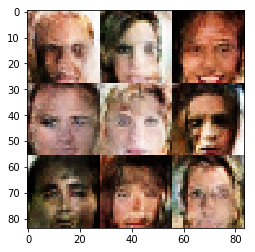

('Epoch 1/4...', 'Discriminator Loss: 1.2135...', 'Generator Loss: 0.8396')
('Epoch 1/4...', 'Discriminator Loss: 0.9735...', 'Generator Loss: 1.5747')
('Epoch 1/4...', 'Discriminator Loss: 1.1624...', 'Generator Loss: 0.9527')
('Epoch 1/4...', 'Discriminator Loss: 1.1931...', 'Generator Loss: 1.0444')
('Epoch 1/4...', 'Discriminator Loss: 1.1116...', 'Generator Loss: 1.0739')
('Epoch 1/4...', 'Discriminator Loss: 1.0627...', 'Generator Loss: 1.2045')
('Epoch 1/4...', 'Discriminator Loss: 1.0482...', 'Generator Loss: 1.3046')
('Epoch 1/4...', 'Discriminator Loss: 1.1513...', 'Generator Loss: 0.8051')
('Epoch 1/4...', 'Discriminator Loss: 1.0595...', 'Generator Loss: 1.1800')
('Epoch 1/4...', 'Discriminator Loss: 1.3271...', 'Generator Loss: 0.7906')


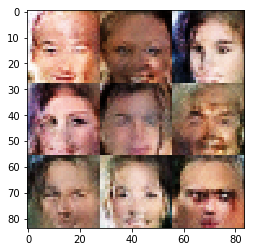

('Epoch 1/4...', 'Discriminator Loss: 1.2077...', 'Generator Loss: 0.8042')
('Epoch 1/4...', 'Discriminator Loss: 1.1750...', 'Generator Loss: 0.8647')
('Epoch 1/4...', 'Discriminator Loss: 1.1301...', 'Generator Loss: 0.9040')
('Epoch 1/4...', 'Discriminator Loss: 1.2201...', 'Generator Loss: 0.7645')
('Epoch 1/4...', 'Discriminator Loss: 1.0899...', 'Generator Loss: 0.8403')
('Epoch 1/4...', 'Discriminator Loss: 1.1015...', 'Generator Loss: 0.9664')
('Epoch 2/4...', 'Discriminator Loss: 1.0092...', 'Generator Loss: 1.2077')
('Epoch 2/4...', 'Discriminator Loss: 1.0961...', 'Generator Loss: 1.2914')
('Epoch 2/4...', 'Discriminator Loss: 0.9604...', 'Generator Loss: 1.4305')
('Epoch 2/4...', 'Discriminator Loss: 1.1176...', 'Generator Loss: 0.8633')


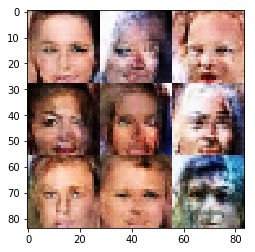

('Epoch 2/4...', 'Discriminator Loss: 1.1303...', 'Generator Loss: 0.8622')
('Epoch 2/4...', 'Discriminator Loss: 1.1617...', 'Generator Loss: 0.8437')
('Epoch 2/4...', 'Discriminator Loss: 1.1480...', 'Generator Loss: 1.1048')
('Epoch 2/4...', 'Discriminator Loss: 1.4639...', 'Generator Loss: 0.4779')
('Epoch 2/4...', 'Discriminator Loss: 1.2457...', 'Generator Loss: 0.7969')
('Epoch 2/4...', 'Discriminator Loss: 1.1428...', 'Generator Loss: 0.8737')
('Epoch 2/4...', 'Discriminator Loss: 1.0913...', 'Generator Loss: 1.1394')
('Epoch 2/4...', 'Discriminator Loss: 1.2171...', 'Generator Loss: 0.7951')
('Epoch 2/4...', 'Discriminator Loss: 1.0353...', 'Generator Loss: 1.0157')
('Epoch 2/4...', 'Discriminator Loss: 1.2821...', 'Generator Loss: 1.0572')


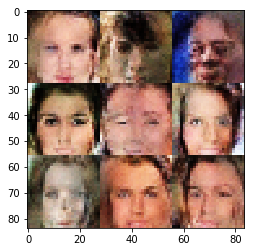

('Epoch 2/4...', 'Discriminator Loss: 1.1623...', 'Generator Loss: 0.8681')
('Epoch 2/4...', 'Discriminator Loss: 1.0895...', 'Generator Loss: 0.8618')
('Epoch 2/4...', 'Discriminator Loss: 1.0788...', 'Generator Loss: 0.9777')
('Epoch 2/4...', 'Discriminator Loss: 1.0592...', 'Generator Loss: 1.3535')
('Epoch 2/4...', 'Discriminator Loss: 1.1650...', 'Generator Loss: 1.1231')
('Epoch 2/4...', 'Discriminator Loss: 1.3357...', 'Generator Loss: 0.6136')
('Epoch 2/4...', 'Discriminator Loss: 1.1422...', 'Generator Loss: 0.7978')
('Epoch 2/4...', 'Discriminator Loss: 1.4159...', 'Generator Loss: 1.3017')
('Epoch 2/4...', 'Discriminator Loss: 1.1111...', 'Generator Loss: 1.1069')
('Epoch 2/4...', 'Discriminator Loss: 1.1316...', 'Generator Loss: 0.9650')


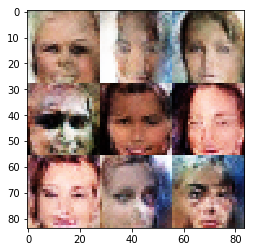

('Epoch 2/4...', 'Discriminator Loss: 1.1958...', 'Generator Loss: 1.2435')
('Epoch 2/4...', 'Discriminator Loss: 1.0580...', 'Generator Loss: 1.1155')
('Epoch 2/4...', 'Discriminator Loss: 1.0976...', 'Generator Loss: 1.0696')
('Epoch 2/4...', 'Discriminator Loss: 1.1782...', 'Generator Loss: 0.7787')
('Epoch 2/4...', 'Discriminator Loss: 1.1366...', 'Generator Loss: 1.2392')
('Epoch 2/4...', 'Discriminator Loss: 1.2460...', 'Generator Loss: 0.7051')


In [ ]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)